* Topic:        Challenge Set 3
* Subject:      Pandas (Exploring and visualizing our scraped movie data in pandas)
* Date:         TODO
* Name:         Michael Green ( malexgreen@gmail.com )

What data do I need to read in if I'm going to scrape IMDB.com?

Here's what is in `GITROOT/challenges/challenges_data/2013_movies.csv`

```csv
Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate

```

So if I'm going to scrape IMDB, I'll need the same data:

* `title`: Name of the movie
* `budget`: How much money was spent to make the movie
* `domesticTotalGross`: How much money did the movie make in gross ticket sales in the US
* `rating`: MPAA Rating
* `director`: Name of the director
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT

Note: This code will be reused for [Project 2](https://github.com/michael-a-green/onl20_ds4/blob/master/curriculum/project-02/project-02-introduction/project_02.md). Some of the fetures extracted in this notebook are used for this challenge (Challenge Set 3) and other features are used in the project.

Below are the features that are extracted in this notebook that are used for the challenge:

* `title`: Name of the movie
* `budget`: How much money was spent to make the movie
* `domesticTotalGross`: How much money did the movie make in gross ticket sales in the US
* `rating`: MPAA Rating
* `director`: Name of the director
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT

Below are the features that will be used in the linear regression that will be performed in Project 2:

* `budget`: How much money was spent to make the movie
* `rating`: MPAA Rating, one-hot encoded
* `encodedDirector`: Name of the director, but encoded in a specific way that will be explained below
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT
* `genre` one-hot encoded. See below for more details
* `runtime` measured in minutes
* `encodedCast1` one-hot encoded value of the name of a cast member if that cast member is in a specific list of cast members. Details of the encoding are explained below
* `encodedCast2` one-hot encoded value of the name of a another cast member if that cast member is in a specific list of cast members. Details of the encoding are explained below




Notes on imdb.com web page structure:

I searched for the move _Star Wars: Episode IV - A New Hope_.

This is the URL it gave to me:
`https://www.imdb.com/title/tt0076759/?ref_=nv_sr_srsg_0`

This is where I found the content I need for this page`<div>` of a movie entry:

```html
<div id="pagecontent" class="pagecontent">
    <div id="main_bottom" class="main">
        
        <div class="article" id="titleStoryLine">
            
        </div>
    
    
    <div class="article" id="titleDetails">

        <div class="txt-block>
            <h4 class="inline">Release Date:</h4>
            " 25 May 1977 (USA) "
            <!-- more stuff see web page for details -->
        </div>
        <div class="txt-block>
            <h4 class="inline">Also Known As:</h4>
            " Star Wars: Episode IV - A New Hope "
             <!-- more stuff see web page for details -->
        </div>
        <h3 class="subheading">Box Office</h3>
        <div class="txt-block">
            <h4 class="inline">Budget:</h4>
            "$11,000,000 "
            <!-- more stuff see web page for details -->
        </div>
        <div class="txt-block">
            <h4 class="inline">Gross USA:</h4>
            " $460,998,507 "
        </div>
        
    </div>

</div>


```

# Data Scraping and Cleaning

In [298]:
#Just going to try beautiful soup to see if I can grab all of the txt-blocks
from bs4 import BeautifulSoup
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import pickle
import os
import datetime
import seaborn as sns
import math
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score



In [133]:
#movie module
from mymovie import Movie

In [134]:
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

In [135]:
def my_wait(start,stop):
    """
    waits a number of seconds randomly selected between start and stop
    """
    if start <= 0:
        start = 10
    
    if stop <= 0:
        stop = 30
    
    if stop <= start:
        stop = start + 10
    
    wait_time = randint(start,stop)
    
    time.sleep(wait_time)
    
    return
    

In [136]:
def my_print(print_string,debug=0,LOG_FILE=None):
    """
    LOG_FILE = Must be a file handle
    """
    
    if (debug):
        if (LOG_FILE == None):
            print(print_string)
        else:
            print(print_string, file=LOG_FILE)


In [137]:
star_wars = Movie("Star Wars Episode IV","www.intel.com")
my_print(star_wars,1)

title = Star Wars Episode IV domesticTotalGross = 0 rating =  director =  releaseDate =  runtime = 0 cast1 =  cast2 =  cast3 =   genre =  budget = 0 star_rating = 0 directlink_url = www.intel.com


In [138]:
#search for movies released in 2013

#Set DEBUG to some_value >= 1 if you want to see debug messages
DEBUG = 1
log_file_name = "notebook.log"
LOG_FILE = open(log_file_name,"w")

RANDOM_STATE = 42

RUN_SCRAPE = 0

#possibly better search
#search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&certificates=US%3AG,US%3APG,US%3APG-13,US%3AR,US%3ANC-17"
#search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2013-01-01,2013-12-31"

search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&certificates=US%3AG,US%3APG,US%3APG-13,US%3AR,US%3ANC-17&countries=us"

IMDB_ROOT_URL = "http://www.imdb.com"

list_of_movie_objects = []

#flag that tells me if this is the first search I 
#sent to IMDB or not (1 means it's the first search, 0 means it's a subsequent search)
first_search = 1

NUMBER_OF_MOVIES = 4000
NUMBER_OF_MOVIES_PER_SEARCH = 50

#won't exactly get the number of movies I want but won't get
#less than the number of movies I want
if (NUMBER_OF_MOVIES % NUMBER_OF_MOVIES_PER_SEARCH) == 0:
    number_of_searches = NUMBER_OF_MOVIES // NUMBER_OF_MOVIES_PER_SEARCH
else:
    number_of_searches = (NUMBER_OF_MOVIES // NUMBER_OF_MOVIES_PER_SEARCH) + 1


#FOR DEBUG ONLY
#hard coding number_of_searches
#number_of_searches = 3


    

In [139]:
#search IMD for movies
#find direct link to movies
#create a movie object with the title and the link to the movie
#write it to a pickle file
#find link to next search
if RUN_SCRAPE:
    for i in range(number_of_searches):
    
        my_print("\nwaiting before I scrape...", DEBUG, LOG_FILE)
        my_wait(10,35)
        my_print("done waiting", DEBUG, LOG_FILE)
        
        if os.path.isfile("STOP_SEARCHING.txt"):
            print("Saw file STOP_SEARCHING.txt. So will stop searching for movies")
            break
    
        #DANGER: INITIATE SEARCH REQUEST TO IMDB
        web_response = requests.get(search_url)
    
        if (web_response.status_code == 200):
            my_print("web request was good", DEBUG, LOG_FILE)
        else:
            print("error: web request failed",DEBUG, LOG_FILE)
            break
    
        #contains IMDB movie search results
        web_response_text = web_response.text
        my_print("got web response text", DEBUG, LOG_FILE)
    
        #convert web response to a soup object
        web_response_soup = BeautifulSoup(web_response_text)
    
        my_print("got web response soup", DEBUG, LOG_FILE)
    
        #the <div> that has the data I want is this one
        listOfListerItemContentDIV = web_response_soup.find_all("div",class_="lister-item-content")
    
        my_print("got divs for movies", DEBUG, LOG_FILE)
    
        if first_search == 1:
            PICKLE_FILE = open("Movie_objects.pkl","wb")
            my_print("opening pickle file for writing", DEBUG, LOG_FILE)
        else:
            PICKLE_FILE = open("Movie_objects.pkl","ab")
            my_print("opening pickle file for appending", DEBUG, LOG_FILE)


    
        #########################################################
        #
        # search through the <div class_="lister-item-content> tags
        # looking for the information I want
        #
        ###########################################################
        for listerItemContentDIV in listOfListerItemContentDIV:
        
            #these accesses  rely on the knowledge of the structure
            #of the web page. hopefully it doesn't change a lot
            link_to_movie = listerItemContentDIV.h3.a.get("href")
            title_of_the_movie = listerItemContentDIV.h3.a.text
            link_to_movie = IMDB_ROOT_URL + link_to_movie
        
        
            #CREATING MOVIE OBJECT
            themovie = Movie(title_of_the_movie,link_to_movie)
        
            my_print(themovie, DEBUG, LOG_FILE)
        
            if themovie != None:
                #TODO: Check status of pickle.dump() call for error
                pickle.dump(themovie,PICKLE_FILE)
            else:
                my_print("error: themovie is None and should not be!", 1, LOG_FILE)
                break
        
            my_print("done writing pickl file", DEBUG, LOG_FILE)
        
        #we found the first 50 movie links
        #close the pickle
        PICKLE_FILE.close()
        #wait a little to give time to flush the file buffer
        my_wait(1,3)
    
        #grab link to the next 50 movies
        #The links are in the <div class="desc">
        listOfDescDIV = web_response_soup.find_all("div",class_="desc")
    
        #Big assumption. There will be two <div class="desc">
        #tags on the search web page, and that the "Next" link and the
        #"Previous" link will be in that <div> tag. So you can
        #always pick the first one
        DescDIV_a_tag = listOfDescDIV[0].find_all("a")
    
        for a_tag in DescDIV_a_tag:
            temp_text = a_tag.text
            if re.match(r"Next",temp_text):
                link_to_next_page = IMDB_ROOT_URL + a_tag.get("href")
    
        #going to try this
        #get text for DIV
        #pass it to soup to get another soup object
    
        my_print("link to next search page is {}".format(link_to_next_page), DEBUG, LOG_FILE)

    
        #doing this for debug purposes --> making debugging easier
    
        search_url = link_to_next_page
        first_search = 0
else:
    print("Skipping scrape")
    

Skipping scrape


In [140]:
if RUN_SCRAPE:
    #Check Code Uncomment to check pickle file
    #also reference for sear
    #Just going to grab all of the Movie objects out of the pickle file and see if they all got in
    PICKLE_FILE = open("Movie_objects.pkl","rb")

    #saving it here as a backup just in case I get locked out
    #at least I'll have the data
    EXPANDED_PICKLE_FILE = open("Movie_populated_objects.pkl","wb")
    list_of_populated_movies = []
    while 1:
                
        if os.path.isfile("STOP_EXPANDING.txt"):
            print("Saw file STOP_EXPANDIN.txt. So will stop populating movies.")
            break
            
        try:
            mymovie = pickle.load(PICKLE_FILE)
            mymovie.populate_movie(DEBUG=1,LOG_FILE=LOG_FILE,start_time=5,stop_time=17)
            #list_of_populated_movies.append(mymovie)
            pickle.dump(mymovie,EXPANDED_PICKLE_FILE)
            #uncomment for debugging only

            my_print(mymovie, DEBUG, LOG_FILE)
        
        except EOFError:
            break

    PICKLE_FILE.close()
    EXPANDED_PICKLE_FILE.close()
else:
    print("Skipping scrape")

Skipping scrape


Note if you are debugging and want to read in the full dataset, that file is called `Movie_populated_objects_4000.pkl`. You should copy that file to the name `Movie_populated_objects_4000.pkl` before running the next and subsequent shell. 

**TODO**: May add shell commmands to this automatically

How many movies did I scrape?

In [141]:
#Read In pickle file of populated objects
list_of_populated_movies = []
EXPANDED_PICKLE_FILE = open("Movie_populated_objects.pkl","rb")
while 1:
    
    try:
        mymovie = pickle.load(EXPANDED_PICKLE_FILE)
        list_of_populated_movies.append(mymovie)
        my_print(mymovie, DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE Reading in movie objects",DEBUG,LOG_FILE)
        break

EXPANDED_PICKLE_FILE.close()
print("Number of movies read: {}".format(len(list_of_populated_movies)))


Number of movies read: 4000


In [142]:
#creating a dictionary of the entries of each movie object
Movie.__dict__.keys()

dict_keys(['__module__', '__doc__', '__init__', '__repr__', 'populate_movie', '__dict__', '__weakref__'])

In [143]:
column_names_in_df = list(list_of_populated_movies[0].__dict__.keys())
my_print(column_names_in_df,DEBUG)

['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director', 'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating']


In [144]:
column_values_in_df = list(list_of_populated_movies[0].__dict__.values())
my_print(column_values_in_df,DEBUG)

['On the Basis of Sex', 'http://www.imdb.com/title/tt4669788/', 24704837, 'PG-13', 'Mimi Leder', '11 January 2019', 'Biography', 120, 'Felicity Jones', 'Armie Hammer', 'Justin Theroux', 20000000, 7.1]


In [145]:

#TODO: Write a get method that takes a data member name as an argument so I can do a 2D comprehension (or at least a for loop) next time or find out how to do that without a get method
list_of_movie_data_lists = []

for movie_key in column_names_in_df:
    
    list_of_movie_data_values = []
    
    for movie_obj in list_of_populated_movies:
        list_of_movie_data_values.append( movie_obj.__dict__[movie_key] )
    
    list_of_movie_data_lists.append(list_of_movie_data_values)

#create dictionary that will be used to create pandas data frame

movie_dict = dict(zip(column_names_in_df,list_of_movie_data_lists))



In [146]:
movie_dict.keys()

dict_keys(['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director', 'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating'])

In [147]:
movie_df = pd.DataFrame(movie_dict)
movie_df.head(10)

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,11 January 2019,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,24 January 2020,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,27 November 2019,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,18 November 2016,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,4 October 2019,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5
5,Avengers: Endgame,http://www.imdb.com/title/tt4154796/,858373000,PG-13,Anthony Russo,26 April 2019,Action,181,Robert Downey Jr.,Chris Evans,Mark Ruffalo,356000000,8.4
6,Interstellar,http://www.imdb.com/title/tt0816692/,188020017,PG-13,Christopher Nolan,7 November 2014,Adventure,169,Matthew McConaughey,Anne Hathaway,Jessica Chastain,165000000,8.6
7,Terminator: Dark Fate,http://www.imdb.com/title/tt6450804/,62253077,R,Tim Miller,1 November 2019,Action,128,Linda Hamilton,Arnold Schwarzenegger,Mackenzie Davis,185000000,6.2
8,Once Upon a Time... in Hollywood,http://www.imdb.com/title/tt7131622/,142502728,R,Quentin Tarantino,26 July 2019,Comedy,161,Leonardo DiCaprio,Brad Pitt,Margot Robbie,90000000,7.6
9,Beauty and the Beast,http://www.imdb.com/title/tt2771200/,504481165,PG,Bill Condon,17 March 2017,Family,129,Emma Watson,Dan Stevens,Luke Evans,160000000,7.1


In [148]:
#don't need lists anymore removing it because it takes a lot of memory
list_of_movie_data_lists = None
column_names_in_df = None

In [149]:
#movie_df[movie_df["rating"]==""]

In [150]:
#movie_df[movie_df["director"]==""]

In [151]:
#movie_df[movie_df["releaseDate"]==""]

In [152]:
#movie_df[movie_df["budget"]==0]

In [153]:

#cast_mask = (movie_df["cast1"]=="") | (movie_df["cast2"]=="") | (movie_df["cast3"]=="")

#movie_df[cast_mask]

In [154]:
#movie_df[ movie_df["star_rating"]==0.0 ]

Removing rows that have an empty value for the following fields:

* `rating`
* `director`
* `releaseDate`
* `genre`
* `runtime`
* `cast[1-3]`
* `budget`


In [155]:
movie_df_processed = movie_df[movie_df["rating"]!=""]

In [156]:
movie_df_processed = movie_df_processed[ movie_df_processed["director"]!="" ]

In [157]:
movie_df_processed = movie_df_processed[ movie_df_processed["releaseDate"]!="" ]

In [158]:
movie_df_processed = movie_df_processed[ movie_df_processed["genre"]!="" ]

In [159]:
movie_df_processed = movie_df_processed[ movie_df_processed["runtime"]!=0 ]

In [160]:
cast_mask = (movie_df["cast1"]!="") | (movie_df["cast2"]!="") | (movie_df["cast3"]!="")
movie_df_processed = movie_df_processed[cast_mask]

<ipython-input-160-2a5a2ac9e943>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movie_df_processed = movie_df_processed[cast_mask]


In [161]:
movie_df_processed = movie_df_processed[ movie_df_processed["budget"]!= 0 ]

Shape of data frame. First number is the number of movies I will be processing.

In [162]:
movie_df_processed.shape

(2127, 13)

Just in case there are duplicates, dropping them here

In [163]:
movie_df_processed.drop_duplicates(inplace=True)

In [164]:
movie_df_processed.shape

(2127, 13)

In [165]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,11 January 2019,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,24 January 2020,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,27 November 2019,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,18 November 2016,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,4 October 2019,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5


In [166]:
movie_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 3994
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2127 non-null   object 
 1   directlink_url      2127 non-null   object 
 2   domesticTotalGross  2127 non-null   int64  
 3   rating              2127 non-null   object 
 4   director            2127 non-null   object 
 5   releaseDate         2127 non-null   object 
 6   genre               2127 non-null   object 
 7   runtime             2127 non-null   int64  
 8   cast1               2127 non-null   object 
 9   cast2               2127 non-null   object 
 10  cast3               2127 non-null   object 
 11  budget              2127 non-null   int64  
 12  star_rating         2127 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 232.6+ KB


Historgram of `star_rating`

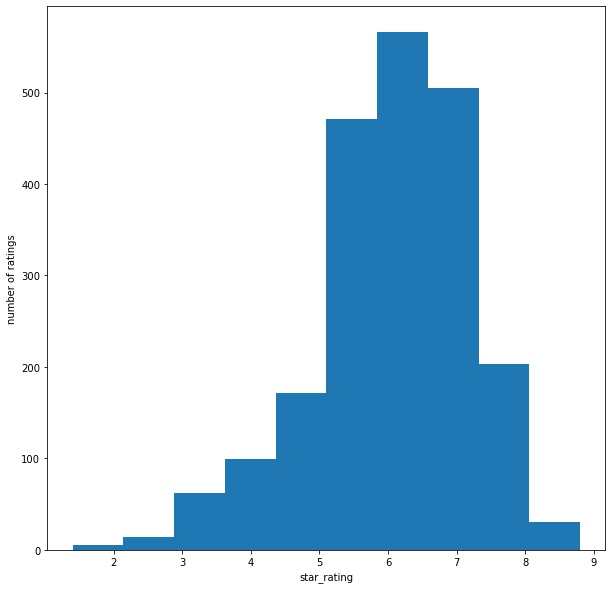

In [167]:
plt.figure(figsize=(10,10))
plt.hist(movie_df_processed["star_rating"],10)
plt.xlabel("star_rating")
plt.ylabel("number of ratings");

Looks like there are a few rating parse issues. Will make them PG-13

In [168]:
movie_df_processed["rating"] = movie_df_processed["rating"].replace({"PG-":"PG-13"})

In [169]:
#len(movie_df_processed["director"].value_counts())

In [170]:
#len(movie_df_processed["genre"].value_counts())

In [171]:
#len(movie_df_processed["cast1"].value_counts())

In [172]:
#len(movie_df_processed["cast2"].value_counts())

In [173]:
#len(movie_df_processed["cast3"].value_counts())

Convert data into a format that can be used in a linear model

In [174]:
movie_df_processed["releaseDate"] = pd.to_datetime(movie_df_processed["releaseDate"])

In [175]:
#movie_df_processed.head()

In [176]:
#type(movie_df_processed.iloc[0,5])

In [177]:
movie_df_processed["releaseMonth"] = movie_df_processed["releaseDate"].dt.month_name()
movie_df_processed["releaseYear"] = movie_df_processed["releaseDate"].dt.year

#save for a different processing for a second model
movie_df_processed2 = movie_df_processed.copy()

In [178]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating,releaseMonth,releaseYear
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1,January,2019
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,2020-01-24,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9,January,2020
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,2019-11-27,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9,November,2019
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,2016-11-18,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3,November,2016
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5,October,2019


In [179]:
#movie_df_processed.sort_values(["releaseDate"],inplace=True)
#plt.figure(figsize=(10,10))
#plt.scatter(movie_df_processed["releaseDate"],movie_df_processed["star_rating"],alpha=0.2)

In [180]:
#avg star rating per release Month
#movie_avg_star_per_relmonth_df = movie_df_processed.groupby(["releaseMonth"])["star_rating"].mean().reset_index()
#movie_avg_star_per_relmonth_df.sort_values("star_rating",ascending=False)

NOTE: Need to do a weighted rating for crew/cast. Mult avg rating by number of times name appears in DF

In [181]:
#movie_avg_star_per_director_df = movie_df_processed.groupby(["director"])["star_rating"].mean().reset_index()
#movie_avg_star_per_director_df.sort_values("star_rating",ascending=False).head(50)


"Bob Persichetti" is a one-hit wonder. So can't just go by average alone. Maybe `avg * number_of_movies * oscar_factor`

In [182]:
#movie_df_processed[ movie_df_processed["director"] == "Bob Persichetti"  ]["title"].count()

In [183]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director',
       'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget',
       'star_rating', 'releaseMonth', 'releaseYear'],
      dtype='object')

I am attempting to create a model that will predict star rating on opening day of the movie. So I cannot use features that become available after opening day. So I will drop these features:
* `domesticTotalGross`

In [184]:
movie_df_processed.drop(["domesticTotalGross"],inplace=True,axis=1)

In [185]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear'],
      dtype='object')

# Exploratory Data Analysis

Correlation Matrix

In [186]:
movie_df_processed.corr()

,runtime,budget,star_rating,releaseYear
runtime,1.000000,0.455620,0.519328,0.112327
budget,0.455620,1.000000,0.308271,0.018657
star_rating,0.519328,0.308271,1.000000,0.072808
releaseYear,0.112327,0.018657,0.072808,1.000000


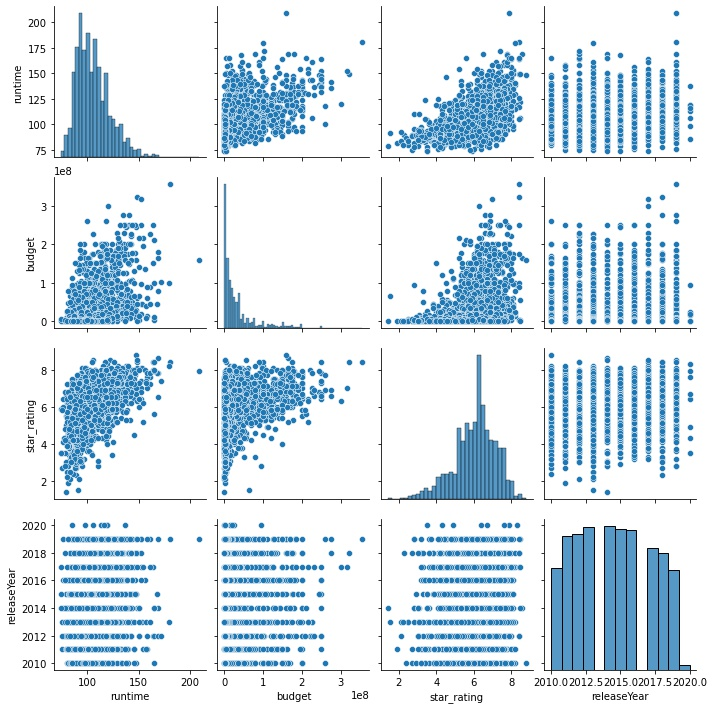

In [187]:
sns.pairplot(movie_df_processed)

Action Notes:
* Create a new feature $log(budget)$



Plotting Rating versus budget

In [188]:

rating_budget_series = movie_df_processed[["star_rating","budget"]]
rating_budget_series.sort_values(["budget"],inplace=True)
#rating_budget_series

<ipython-input-188-d6e8cc662c66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_budget_series.sort_values(["budget"],inplace=True)


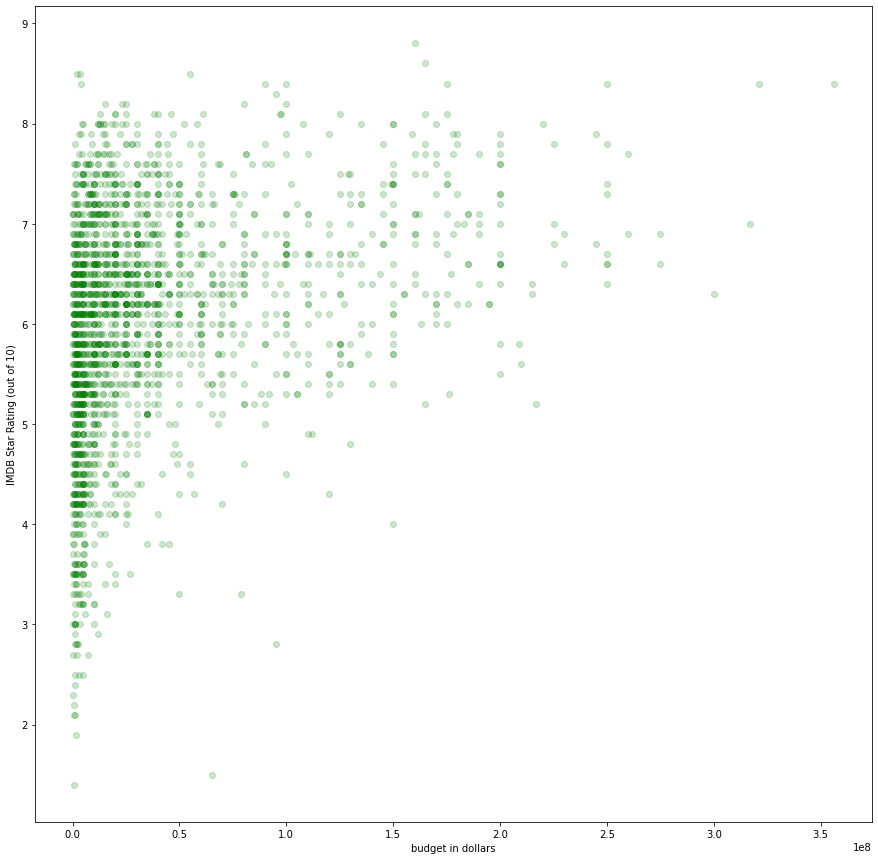

In [189]:
plt.figure(figsize=(15,15))
plt.scatter(rating_budget_series["budget"],rating_budget_series["star_rating"],alpha=0.2,color="green")
plt.xlabel("budget in dollars")
plt.ylabel("IMDB Star Rating (out of 10)");

Notes about graph
* unless budget is over \$50M it does not seem to inform what the rating will be
* After budget gets to \$50M it looks like star rating is a logarithmic function of budget

<ipython-input-190-d7ab0ed6e3bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_relyear_series.sort_values(["releaseYear"],inplace=True)


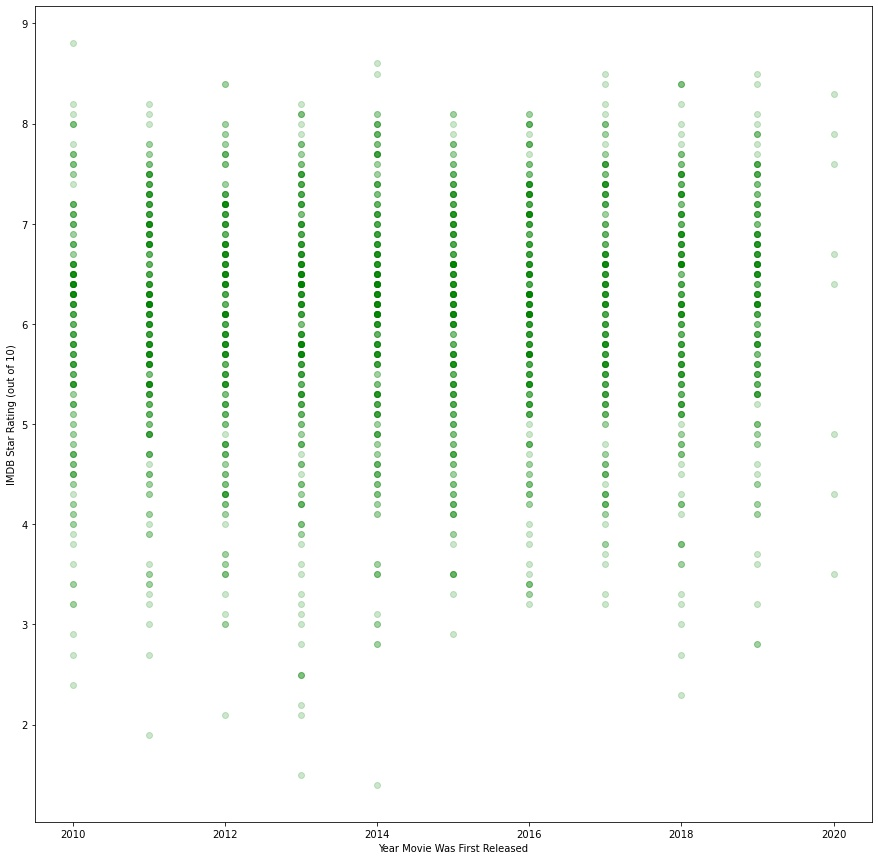

In [190]:
rating_relyear_series = movie_df_processed[["star_rating","releaseYear"]]
rating_relyear_series.sort_values(["releaseYear"],inplace=True)
plt.figure(figsize=(15,15))
plt.scatter(rating_relyear_series["releaseYear"],rating_relyear_series["star_rating"],alpha=0.2,color="green")
plt.xlabel("Year Movie Was First Released")
plt.ylabel("IMDB Star Rating (out of 10)");
#rating_budget_series

Notes on graph
* release year doesn't affect IMDB score. Seems with respect to year, IMDB score is random
* In 2016 is seems IMDB ratings had a high lower bound than other years. Is there a way to include this in the model? Is it significant enough. Correlation says 

In [191]:
#sns.pairplot(movie_df_processed)

## Creating One-Hot Encoded Variables

one hot encode date and genre

In [192]:
one_hot_encoded_release_month_series = pd.get_dummies(movie_df_processed["releaseMonth"],drop_first=True)


In [193]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_release_month_series], axis=1)

In [194]:
one_hot_encoded_genre_series = pd.get_dummies(movie_df_processed["genre"],drop_first=True)

In [195]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_genre_series], axis=1)

In [196]:
one_hot_encoded_mpaa_rating = pd.get_dummies(movie_df_processed["rating"],drop_first=True)

In [197]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_mpaa_rating], axis=1)

In [198]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13',
       'R'],
      dtype='object')

# Baseline Model

I kept around some fields to help me understand the data. I will now create the dataframe that will be used to fit the model

```python

movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R']]

```

In [199]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget','August', 'December', 'February',
                                           'January', 'July', 'June', 'March', 'May', 'November', 'October','September',
                                           'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime','Drama', 'Family',
                                           'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13','R']]

In [200]:
movie_for_modeling_df.head()

,star_rating,runtime,budget,August,December,February,January,July,June,March,...,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R
0,7.1,120,20000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,7.9,113,22000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,7.9,130,40000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6.3,92,20000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,8.5,122,55000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [201]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)


In [202]:
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

In [203]:
print(X_train.shape,X_val.shape,X_test.shape)

(1701, 33) (213, 33) (213, 33)


In [204]:
print(Y_train.shape,Y_val.shape,Y_test.shape)

(1701,) (213,) (213,)


In [205]:
baseline_model = LinearRegression()
baseline_model.fit(X_train,Y_train)
train_baseline_score = baseline_model.score(X_train,Y_train)
val_baseline_score = baseline_model.score(X_val,Y_val)
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))

train baseline score 0.3627831104901339 validation baseline score 0.3027510089508578


Looking at coefficients of the model


In [206]:
list(zip(X_train.columns, baseline_model.coef_))

[('runtime', 0.03019040789532793),
 ('budget', 3.1423114972448543e-09),
 ('August', 0.06817277808996197),
 ('December', -0.08060671521070614),
 ('February', -0.03342718817577748),
 ('January', 0.06320038850827167),
 ('July', -0.034175748108312504),
 ('June', 0.0619544471582607),
 ('March', -0.050343360528324964),
 ('May', -0.16863110286217514),
 ('November', 0.09665129139034301),
 ('October', 0.017673488147092586),
 ('September', 0.08948194476539474),
 ('Adventure', 0.21240345375326958),
 ('Animation', 0.8962578686319748),
 ('Biography', 0.8183333713964259),
 ('Comedy', 0.30122931694056465),
 ('Crime', 0.34794591142755044),
 ('Drama', 0.41283030135073284),
 ('Family', -0.4701771357195171),
 ('Fantasy', -0.09984260922466283),
 ('Horror', -0.09226636037729707),
 ('Music', 1.83342101354469),
 ('Musical', 1.6930671861242668),
 ('Mystery', 1.0362735424148244),
 ('Romance', 0.38549666143521105),
 ('Sci-Fi', 1.942890293094024e-13),
 ('Sport', 0.023434873889158297),
 ('Thriller', -0.6708225264

In [207]:
baseline_model.intercept_

2.4395250660687657

### Doing a 5 fold cross validation


In [208]:
baseline_model = LinearRegression()
kfold_object = KFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE)
baseline_model_cv_results = cross_val_score(baseline_model, X_train_val, Y_train_val,scoring="r2",cv=kfold_object)
baseline_model_cv_results_mean = np.mean(baseline_model_cv_results)
baseline_model_cv_results_stddev = np.std(baseline_model_cv_results)
print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(baseline_model_cv_results,baseline_model_cv_results_mean,baseline_model_cv_results_stddev))


scores -> [0.27118108 0.40097311 0.24833546 0.23969836 0.33214733 0.28167666
 0.4694296  0.36743783 0.39732994 0.29323579]
mean -> 0.33014451746788454
standard deviation -> 0.07237887144333242



## Adding Features to Improve the Model

I hypothesize that the director and cast have a strong influence on the `star_rating`

So I am creating a feature called `star_power` that I hope is linearly related to `star_rating`

I will then use this feature along with the others to hopefully train a better model.

If director helps I will factor in cast as well.

Psuedocode equation for star power:

```
star_power["movie"] = Number_of_Oscars["director"]
```


In [209]:
Best_Directors = ["Tom Hooper", "Darren Aronofsky",
                  "Joel Coen", "Ethan Coen",
                  "David Fincher", "David O. Russell",
                  "Woody Allen","Michel Hazanavicius", "Terrence Malick",
                  "Alexander Payne", "Martin Scorsese",
                  "Michael Haneke", "David O. Russell","Ang Lee",
                  "Steven Spielberg", "Benh Zeitlin",
                  "Steve McQueen", "Alexander Payne","Alfonso Cuarón",
                  "David O. Russell", "Martin Scorsese","Alejandro G. Iñárritu",
                  "Wes Anderson","Richard Linklater","Alejandro G. Iñárritu",
                  "Bennet Miller","Morten Tyldum","Alejandro G. Iñárritu",
                  "Lenny Abrahamson","Tom McCarthy",
                  "Adam McKay", "George Miller",
                  "Mel Gibson", "Barry Jenkins","Damien Chazelle"
                  "Kenneth Lonegran", "Denis Villeneuve","Guillermo del Toro"
                  "Paul Thomas Anderson", "Greta Gerwig",
                  "Christopher Nolan","Jordan Peele","Alfonso Cuarón"
                  "Yorgos Lanthimos","Spike Lee",
                  "Adam McKay","Pawel Pawlikowski","Bong Joon-ho"
                  "Sam Mendes","Todd Phillips",
                  "Martin Scorsese", "Quentin Tarantino"]
                  
                  


In [210]:

##Creating a new feature called star_power

director_names =  movie_df_processed["director"]
director_names = set(director_names)
movie_df_processed["star_power"] = 0
#mask = movie_df_processed["title"].str.contains("Cold")
#mask = movie_df_processed["director"] == "Alejandro G. Iñárritu"
#movie_df_processed[mask]

for director_name in director_names:
    #current_count = 0
    #for index,row in movie_df.iterrows():
    #    if row["director"] == director_name:
    #        current_count += 1
    director_count = movie_df_processed[ movie_df_processed["director"] == director_name  ]["title"].count()
    total_star_rating = movie_df_processed[ movie_df_processed["director"] == director_name  ]["star_rating"].sum()
    avg_star_rating = total_star_rating/director_count
    
    movie_df_processed.loc[ movie_df_processed["director"] == director_name,"star_power" ] = Best_Directors.count( director_name )

In [211]:
#movie_df_processed["star_power"] = movie_df_processed["star_rating"] + Best_Directors.count( movie_df_processed["director"] )
movie_df_processed.head(5)

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,...,0,0,0,0,0,0,0,1,0,0
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,R,Guy Ritchie,2020-01-24,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,...,0,0,0,0,0,0,0,0,1,0
2,Knives Out,http://www.imdb.com/title/tt8946378/,PG-13,Rian Johnson,2019-11-27,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,...,0,0,0,0,0,0,0,1,0,0
3,Bastille Day,http://www.imdb.com/title/tt2368619/,R,James Watkins,2016-11-18,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,...,0,0,0,0,0,0,0,0,1,0
4,Joker,http://www.imdb.com/title/tt7286456/,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,...,0,0,0,0,0,0,0,0,1,1


In [212]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R',
       'star_power'],
      dtype='object')

I'm doing this to compare the star power number between a director that has one at least one Oscar and a director that has not.

In [213]:
mask = (movie_df_processed["director"]=="Alejandro G. Iñárritu") | (movie_df_processed["director"]=="Mimi Leder")

movie_df_processed[mask]

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,...,0,0,0,0,0,0,0,1,0,0
93,The Revenant,http://www.imdb.com/title/tt1663202/,R,Alejandro G. Iñárritu,2016-01-08,Action,156,Leonardo DiCaprio,Tom Hardy,Will Poulter,...,0,0,0,0,0,0,0,0,1,3
281,Birdman or (The Unexpected Virtue of Ignorance),http://www.imdb.com/title/tt2562232/,R,Alejandro G. Iñárritu,2014-11-14,Comedy,119,Michael Keaton,Zach Galifianakis,Edward Norton,...,0,0,0,0,0,0,0,0,1,3


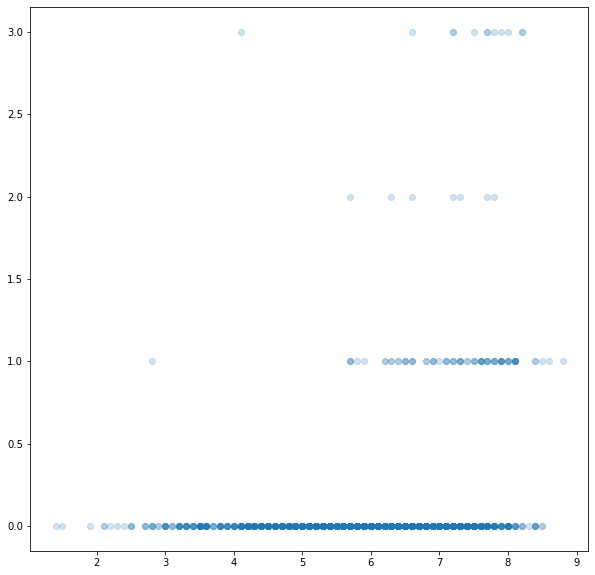

In [214]:
#TODO: Add title and labels for X and Y axes
movie_df_processed.sort_values(["star_rating"],inplace=True)
plt.figure(figsize=(10,10))
plt.scatter(movie_df_processed["star_rating"],movie_df_processed["star_power"],alpha=0.2)

In [215]:
movieProcessedAVGStarPowerPerDirector = movie_df_processed.groupby(["director"])["star_power"].mean().reset_index()
movieProcessedAVGStarPowerPerDirector.sort_values(["star_power"],inplace=True,ascending=False)
movieProcessedAVGStarPowerPerDirector.head()

,director,star_power
24,Alejandro G. Iñárritu,3
836,Martin Scorsese,3
305,David O. Russell,3
36,Alexander Payne,2
8,Adam McKay,2


In [216]:
movieProcessedAVGStarPowerPerDirector.iloc[:10,1]

24      3
836     3
305     3
36      2
8       2
1271    1
1063    1
1043    1
325     1
40      1
Name: star_power, dtype: int64

<BarContainer object of 10 artists>

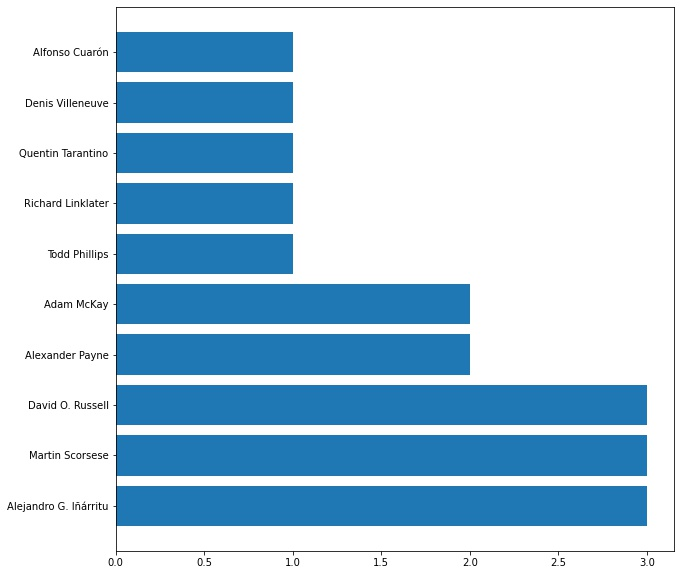

In [217]:
#top 10 directors by star power
plt.figure(figsize=(10,10))
plt.barh(movieProcessedAVGStarPowerPerDirector.iloc[:10,0],movieProcessedAVGStarPowerPerDirector.iloc[:10,1])

Plot appears to make sense. 

<BarContainer object of 10 artists>

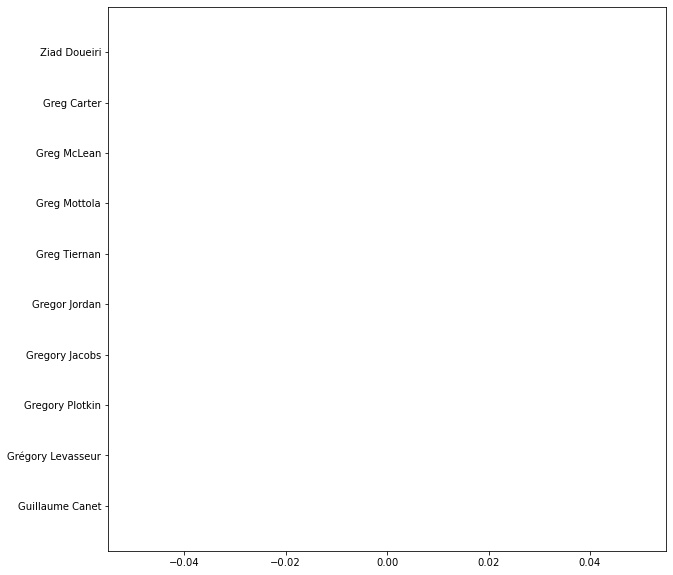

In [218]:
#bottom 10 directors by star power
plt.figure(figsize=(10,10))
plt.barh(movieProcessedAVGStarPowerPerDirector.iloc[-10:,0],movieProcessedAVGStarPowerPerDirector.iloc[-10:,1])

In [219]:
movie_df_processed.head(5)

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power
2512,Kirk Cameron's Saving Christmas,http://www.imdb.com/title/tt4009460/,PG,Darren Doane,2014-11-14,Comedy,79,Kirk Cameron,Darren Doane,Bridgette Cameron,...,0,0,0,0,0,0,1,0,0,0
2324,Foodfight!,http://www.imdb.com/title/tt0249516/,PG,Lawrence Kasanoff,2013-02-12,Animation,91,Hilary Duff,Haylie Duff,Charlie Sheen,...,0,0,0,0,0,0,1,0,0,0
3759,The Life Zone,http://www.imdb.com/title/tt1786714/,PG-13,Rod Weber,2011-06-10,Horror,81,Robert Loggia,Lindsey Haun,Martin Kove,...,0,0,0,0,0,0,0,1,0,0
3516,American Idiots,http://www.imdb.com/title/tt1698651/,R,Robert Taleghany,2013-06-18,Comedy,92,Jeffrey T. Schoettlin,Sean Muramatsu,Caroline D'Amore,...,0,0,0,0,0,0,0,0,1,0
3934,Snow White: A Deadly Summer,http://www.imdb.com/title/tt2149137/,PG-13,David DeCoteau,2012-03-16,Horror,83,Shanley Caswell,Maureen McCormick,Eric Roberts,...,0,0,0,0,0,0,0,1,0,0


In [220]:

#TODO: If you need to incorporate actors into star power number start here
#movie_avg_star_per_cast1_df = movie_df_processed.groupby(["cast1"])["star_rating"].mean().reset_index()
#movie_avg_star_per_cast1_df.sort_values("star_rating",ascending=False).head(50)

From pair plot above I should add a feature that is budget^2


In [221]:
movie_df_processed["budget2"] = movie_df_processed["budget"]**2 - 100000000

I looked at the `star_rating` vs `budget` plot and it looks logarithmic to me so will add that feature instead

In [222]:

movie_df_processed["log_budget"] = movie_df_processed["budget"].apply(lambda x : math.log(x))

In [223]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R',
       'star_power', 'budget2', 'log_budget'],
      dtype='object')

In [224]:
movie_df_processed.head()

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power,budget2,log_budget
2512,Kirk Cameron's Saving Christmas,http://www.imdb.com/title/tt4009460/,PG,Darren Doane,2014-11-14,Comedy,79,Kirk Cameron,Darren Doane,Bridgette Cameron,...,0,0,0,0,1,0,0,0,249900000000,13.122363
2324,Foodfight!,http://www.imdb.com/title/tt0249516/,PG,Lawrence Kasanoff,2013-02-12,Animation,91,Hilary Duff,Haylie Duff,Charlie Sheen,...,0,0,0,0,1,0,0,0,4224999900000000,17.989898
3759,The Life Zone,http://www.imdb.com/title/tt1786714/,PG-13,Rod Weber,2011-06-10,Horror,81,Robert Loggia,Lindsey Haun,Martin Kove,...,0,0,0,0,0,1,0,0,2249900000000,14.220976
3516,American Idiots,http://www.imdb.com/title/tt1698651/,R,Robert Taleghany,2013-06-18,Comedy,92,Jeffrey T. Schoettlin,Sean Muramatsu,Caroline D'Amore,...,0,0,0,0,0,0,1,0,562400000000,13.527828
3934,Snow White: A Deadly Summer,http://www.imdb.com/title/tt2149137/,PG-13,David DeCoteau,2012-03-16,Horror,83,Shanley Caswell,Maureen McCormick,Eric Roberts,...,0,0,0,0,0,1,0,0,999900000000,13.815511


## Model Improved `star_power`
Here I'm training a model using the new set of predictor values that include `star_power` and `log_budget`

In [225]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R',"star_power","log_budget"]]

In [226]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)


In [227]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)


In [228]:
model2 = LinearRegression()
model2.fit(X_train,Y_train)
train_model2_score = model2.score(X_train,Y_train)
val_model2_score = model2.score(X_val,Y_val)
print("train score {} validation score {}".format(train_model2_score, val_model2_score))

train score 0.3738630410310806 validation score 0.3463544530938557


In [229]:
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))

train baseline score 0.3627831104901339 validation baseline score 0.3027510089508578


I'm seeing a large improvement after adding `star_power` and `log_budget`.

In [230]:
list(zip(X_train.columns, model2.coef_))

[('runtime', 0.02622217111259613),
 ('budget', 9.973389004627585e-11),
 ('August', 0.04178202927674911),
 ('December', -0.17338674324429326),
 ('February', -0.1598971193258246),
 ('January', -0.07845675914950392),
 ('July', -0.10997883612666935),
 ('June', -0.0485333705201657),
 ('March', -0.0929436077790597),
 ('May', -0.19577822480521032),
 ('November', 0.03340918910912878),
 ('October', -0.008632500322393894),
 ('September', -0.002196293872882),
 ('Adventure', 0.3152604334062668),
 ('Animation', 0.8034442749325411),
 ('Biography', 0.8106712656598257),
 ('Comedy', 0.27108362405312686),
 ('Crime', 0.3816805720094031),
 ('Drama', 0.5333218091405201),
 ('Family', -0.5012857240010502),
 ('Fantasy', -0.34316768884359566),
 ('Horror', -0.12082028496691254),
 ('Music', 1.6434697874864368),
 ('Musical', -2.617905892066119e-13),
 ('Mystery', 1.3720830612741783),
 ('Romance', 0.43284622014565227),
 ('Sci-Fi', 0.9805673950062639),
 ('Sport', -2.7255975254547593e-14),
 ('Thriller', -0.5432185620

In [231]:
 model2.intercept_

1.5484268003925576

### Doing a 5 fold cross validation


In [232]:
model2 = LinearRegression()
kfold_object = KFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE)
model2_cv_results = cross_val_score(model2, X_train_val, Y_train_val,scoring="r2",cv=kfold_object)
model2_cv_results_mean = np.mean(model2_cv_results)
model2_cv_results_stddev = np.std(model2_cv_results)
print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(model2_cv_results,model2_cv_results_mean,model2_cv_results_stddev))


scores -> [0.35774753 0.35567792 0.27975638 0.3515864  0.46706487 0.29939107
 0.35342057 0.26043649 0.22423963 0.3928363 ]
mean -> 0.3342157171209269
standard deviation -> 0.06669849938002154



Adding star power for the other cast members below

In [233]:
Best_Actor_Actress = [
    "Colin Firth",
    "Javier Bardem",
    "Jeff Bridges",
    "Jesse Eisenberg",
    "James Franco",
    "Jean Dujardin",
    "Demián Bichir",
    "George Clooney",
    "Gary Oldman",
    "Brad Pitt",
    "Daniel Day-Lewis",
    "Bradely Cooper",
    "Joaquin Phoenix",
    "Denzel Washington",
    "Matthew McConaughey",
    "Christian Bale",
    "Bruce Dern",
    "Leonardo DiCaprio",
    "Chiwetel Ejiofor",
    "Eddie Redmayne",
    "Steve Carell",
    "Bradley Cooper",
    "Benedict Cumerbatch",
    "Michael Keaton",
    "Leonardo DiCaprio",
    "Bryan Cranston",
    "Matt Damon",
    "Michael Fassbender",
    "Eddie Redmayne",
    "Casey Affleck",
    "Andrew Garfield",
    "Ryan Gosling",
    "Viggo Mortensen",
    "Denzel Washington",
    "Gary Oldman",
    "Timothée Chalamet",
    "Daniel Day-Lewis",
    "Daniel Kaluuya",
    "Denzel Washington",
    "Rami Malek",
    "Christian Bale",
    "Bradley Cooper",
    "Willem Dafoe",
    "Viggo Mortensen",
    "Joaquin Phoenix",
    "Antonio Banderas",
    "Leonardo DiCaprio",
    "Adam Driver",
    "Jonathan Pryce",
    "Natalie Portman",
    "Annette Bening",
    "Nicole Kidman",
    "Jennifer Lawrence",
    "Michelle Williams",
    "Meryl Streep",
    "Glen Close",
    "Viola Davis",
    "Rooney Mara",
    "Michelle Williams",
    "Jennifer Lawrence",
    "Jessica Chastain",
    "Emmanuelle Riva",
    "Quvenzhané Wallis",
    "Naomi Watts",
    "Cate Blanchett",
    "Amy Adams",
    "Sandra Bullock",
    "Judi Dench",
    "Meryl Streep",
    "Julianne Moore",
    "Marion Cotillard",
    "Felicity Jones",
    "Rosamund Pike",
    "Reese Witherspoon",
    "Brie Larson",
    "Cate Blanchett",
    "Jennifer Lawrence",
    "Charlotte Rampling",
    "Saoirse Ronan",
    "Emma Stone",
    "Isabelle Huppert",
    "Ruth Negga",
    "Natalie Portman",
    "Meryl Streep",
    "Frances McDormand",
    "Sally Hawkins",
    "Margot Robbie",
    "Saoirse Ronan",
    "Meryl Streep",
    "Olivia Colman",
    "Yalitza Aparicio",
    "Glenn Close",
    "Lady Gaga",
    "Melissa McCarthy",
    "Renée Zellweger",
    "Cynthia Erivo",
    "Scarlette Johansson",
    "Saoirse Ronan",
    "Charlize Theron"
]

In [234]:

features_to_process = ["cast1","cast2","cast3"]

for feature in features_to_process:
    actor_names = movie_df_processed[feature]
    #now it's a unique list of names from the column "feature"
    actor_names = set(actor_names)
    movie_df_processed["{}_starpower".format(feature)] = 0
    
    for actor_name in actor_names:
        movie_df_processed.loc[movie_df_processed[feature] == actor_name,"cast1_starpower"]  = Best_Actor_Actress.count(actor_name)


In [235]:
movie_df_processed

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Western,PG,PG-13,R,star_power,budget2,log_budget,cast1_starpower,cast2_starpower,cast3_starpower
2512,Kirk Cameron's Saving Christmas,http://www.imdb.com/title/tt4009460/,PG,Darren Doane,2014-11-14,Comedy,79,Kirk Cameron,Darren Doane,Bridgette Cameron,...,0,1,0,0,0,249900000000,13.122363,0,0,0
2324,Foodfight!,http://www.imdb.com/title/tt0249516/,PG,Lawrence Kasanoff,2013-02-12,Animation,91,Hilary Duff,Haylie Duff,Charlie Sheen,...,0,1,0,0,0,4224999900000000,17.989898,0,0,0
3759,The Life Zone,http://www.imdb.com/title/tt1786714/,PG-13,Rod Weber,2011-06-10,Horror,81,Robert Loggia,Lindsey Haun,Martin Kove,...,0,0,1,0,0,2249900000000,14.220976,0,0,0
3516,American Idiots,http://www.imdb.com/title/tt1698651/,R,Robert Taleghany,2013-06-18,Comedy,92,Jeffrey T. Schoettlin,Sean Muramatsu,Caroline D'Amore,...,0,0,0,1,0,562400000000,13.527828,0,0,0
3934,Snow White: A Deadly Summer,http://www.imdb.com/title/tt2149137/,PG-13,David DeCoteau,2012-03-16,Horror,83,Shanley Caswell,Maureen McCormick,Eric Roberts,...,0,0,1,0,0,999900000000,13.815511,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842,Disney's Newsies: The Broadway Musical!,http://www.imdb.com/title/tt6346162/,PG,Jeff Calhoun,2017-02-16,Musical,149,Jeremy Jordan,Kara Lindsay,Ben Fankhauser,...,0,1,0,0,0,3999900000000,14.508658,0,0,0
92,Whiplash,http://www.imdb.com/title/tt2582802/,R,Damien Chazelle,2014-10-15,Drama,106,Miles Teller,J.K. Simmons,Melissa Benoist,...,0,0,0,1,0,10889900000000,15.009433,0,0,0
4,Joker,http://www.imdb.com/title/tt7286456/,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,...,0,0,0,1,1,3024999900000000,17.822844,0,0,0
6,Interstellar,http://www.imdb.com/title/tt0816692/,PG-13,Christopher Nolan,2014-11-07,Adventure,169,Matthew McConaughey,Anne Hathaway,Jessica Chastain,...,0,0,1,0,1,27224999900000000,18.921456,1,0,0


## Trying another improvement with more features

Added features `cast[1-3]_starpower`

OK Try to train a third model

In [236]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
                                            'Thriller', 'Western', 'PG', 'PG-13', 'R',"star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]

In [237]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [238]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

print("X_train.shape",X_train.shape)
print("X_val.shape",X_val.shape)
print("X_test.shape",X_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)

X_train.shape (1701, 38)
X_val.shape (213, 38)
X_test.shape (213, 38)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [239]:
model3 = LinearRegression()
model3.fit(X_train,Y_train)
train_model3_score = model3.score(X_train,Y_train)
val_model3_score = model3.score(X_val,Y_val)
print("train score {} validation score {}".format(train_model3_score, val_model3_score))

train score 0.37458934709076463 validation score 0.34693219620199056


In [240]:
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))
print("train score {} validation score {}".format(train_model2_score, val_model2_score))

train baseline score 0.3627831104901339 validation baseline score 0.3027510089508578
train score 0.3738630410310806 validation score 0.3463544530938557


### Doing a 5 fold cross validation


In [241]:
model3 = LinearRegression()
kfold_object = KFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE)
model3_cv_results = cross_val_score(model3, X_train_val, Y_train_val,scoring="r2",cv=kfold_object)
model3_cv_results_mean = np.mean(model3_cv_results)
model3_cv_results_stddev = np.std(model3_cv_results)
print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(model3_cv_results,model3_cv_results_mean,model3_cv_results_stddev))


scores -> [0.35871819 0.3534691  0.27871798 0.35265813 0.46318913 0.30034009
 0.35564552 0.2636748  0.2261153  0.39324207]
mean -> 0.3345770306703422
standard deviation -> 0.06540385721767256



Adding features `cast[1-3]_starpower` improved the validation score

## Trying Automatically Generated Polynomialization

In [242]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [243]:
poly_object = PolynomialFeatures()

#creates a bunch of new features that are polynomializations of the original features

#using X from model 3 above
X_poly = poly_object.fit_transform(X)

#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_p_train_val,X_p_test, Y_train_val,Y_test = train_test_split(X_poly, Y, test_size=0.10, random_state=RANDOM_STATE)
X_p_train, X_p_val, Y_train, Y_val = train_test_split(X_p_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

print("X_p_train.shape",X_p_train.shape)
print("X_p_val.shape",X_p_val.shape)
print("X_p_test.shape",X_p_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)


X_p_train.shape (1701, 780)
X_p_val.shape (213, 780)
X_p_test.shape (213, 780)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [244]:
model4 = LinearRegression()
model4.fit(X_p_train,Y_train)
train_model4_score = model4.score(X_p_train,Y_train)
val_model4_score = model4.score(X_p_val,Y_val)
print("train score {} validation score {}".format(train_model4_score, val_model4_score))

train score 0.3597569530893342 validation score 0.34457400071409927


The number above is strange so re-randomizing my train/val/test data sets and trying again


In [245]:
X_p_train_val,X_p_test, Y_train_val,Y_test = train_test_split(X_poly, Y, test_size=0.10, random_state=RANDOM_STATE+1)
X_p_train, X_p_val, Y_train, Y_val = train_test_split(X_p_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE+1)

print("X_p_train.shape",X_p_train.shape)
print("X_p_val.shape",X_p_val.shape)
print("X_p_test.shape",X_p_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)



X_p_train.shape (1701, 780)
X_p_val.shape (213, 780)
X_p_test.shape (213, 780)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [246]:
model4 = LinearRegression()
model4.fit(X_p_train,Y_train)
train_model4_score = model4.score(X_p_train,Y_train)
val_model4_score = model4.score(X_p_val,Y_val)
print("train score {} validation score {}".format(train_model4_score, val_model4_score))

train score -0.2811683956249309 validation score 0.4226472068897653


In [247]:
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))
print("train score {} validation score {}".format(train_model2_score, val_model2_score))
print("train score {} validation score {}".format(train_model3_score, val_model3_score))

train baseline score 0.3627831104901339 validation baseline score 0.3027510089508578
train score 0.3738630410310806 validation score 0.3463544530938557
train score 0.37458934709076463 validation score 0.34693219620199056


### Doing a 5 fold cross validation


In [248]:
model4 = LinearRegression()
kfold_object = KFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE)
model4_cv_results = cross_val_score(model4, X_p_train_val, Y_train_val,scoring="r2",cv=kfold_object)
model4_cv_results_mean = np.mean(model4_cv_results)
model4_cv_results_stddev = np.std(model4_cv_results)
print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(model4_cv_results,model4_cv_results_mean,model4_cv_results_stddev))


scores -> [  0.29925582   0.24236191 -17.17410109   0.33186519  -3.23321845
   0.35568019   0.36144508   0.30413073   0.37906271   0.31931647]
mean -> -1.7814201446905493
standard deviation -> 5.239490416435931



Running `PolynomialFeatures()` did not improved the model. Moving on to cross-validation of `model3`.

## Regularize `model3`

`model3` training $R^2$ is higher than its validation $R^2$. So there is some over fitting. Going to try to regularize the model to see if I can improve it. 

In [249]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
                                            'Thriller', 'Western', 'PG', 'PG-13', 'R',"star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]

In [250]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [251]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

normalizer = StandardScaler()

#fit it on the training data
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)
X_val_normal = normalizer.transform(X_val.values)

print("X_train_normal.shape",X_train_normal.shape)
print("X_val_normal.shape",X_val_normal.shape)
print("X_test_normal.shape",X_test_normal.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)

X_train_normal.shape (1701, 38)
X_val_normal.shape (213, 38)
X_test_normal.shape (213, 38)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [252]:
#This may take a long time
#model3_shrunk = RidgeCV(alphas=np.linspace(1,100001,1000001),store_cv_values=True,scoring="r2")
#model3_shrunk.fit(X_train_normal,Y_train)
#train_model3_shrunk_score = model3_shrunk.score(X_train_normal,Y_train)
#val_model3_shrunk_score = model3_shrunk.score(X_val_normal,Y_test)
#print("train score {} val score {}".format(train_model3_shrunk_score, val_model3_shrunk_score))

In [253]:
#trying RidgeCV
#model3_shrunk.best_score_


In [254]:
#model3_shrunk.cv_values_

In [255]:
#model3_shrunk.alpha_

In [256]:
#model3_shrunk.cv_values_.shape

In [257]:
#list(zip(X_train.columns,model3_shrunk.coef_))

# Model Conclusions

`model3` was the best model.

It appeared to overfit.

I regenerated the model using normalized data and did Ridge regularization.

I did a very wide search for alpha: `alphas=np.linspace(1,100001,1000001)`

The resultant model scored even worse than the non-regularized version of the model.

So `model3` without regularization seems to be the best model to move forward with a final test_score and analysis.

## Correlation of Numeric features
Generating a final correlation matrix of the generic features


In [258]:
#movie_for_corr_df["cast2_starpower"].value_counts()

In [259]:
#movie_for_corr_df = movie_df_processed[['star_rating','runtime','budget', "star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]
#movie_for_corr_df.corr()

In [260]:
#movie_for_corr_df["cast2_starpower"].value_counts()

In [261]:
#movie_for_corr_df["cast3_starpower"].value_counts()

In [262]:
#sns.pairplot(movie_for_corr_df)

In [263]:
#movie_for_corr_df2 = movie_df_processed[['star_rating','August', 'December', 'February','January', 'July', 'June', 'March',
#                                            'May', 'November', 'October','September']]

In [264]:
#movie_for_corr_df2.corr()

In [265]:
#sns.pairplot(movie_for_corr_df2)

In [266]:
#movie_for_corr_df3 = movie_df_processed[['star_rating',
#                                             'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
#                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
 #                                           'Thriller', 'Western', ]]

In [267]:
#movie_for_corr_df3.corr()

In [268]:
#sns.pairplot(movie_for_corr_df3)

In [269]:
#movie_for_corr_df4 = movie_df_processed[['star_rating',
#                                            
#                                            
#                                            'PG', 'PG-13', 'R']]

In [270]:
#movie_for_corr_df4.corr()

In [271]:
#sns.pairplot(movie_for_corr_df4)

## Test Score for `model3`

In [272]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
                                            'Thriller', 'Western', 'PG', 'PG-13', 'R',"star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]

In [273]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [274]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

print("X_train.shape",X_train.shape)
print("X_val.shape",X_val.shape)
print("X_test.shape",X_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)

X_train.shape (1701, 38)
X_val.shape (213, 38)
X_test.shape (213, 38)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [275]:
model3 = LinearRegression()

#According to a discussion with instructors, it's legal to train the model on the
#validation and training data before calculating R^2 on the test-set.
model3.fit(X_train_val,Y_train_val)
test_model3_score = model3.score(X_test,Y_test)
print("test score {}".format(test_model3_score))

test score 0.3634435525176096


It's better than guessing. A persion would have at most a 1/10 (0.1) chance of guessing the IMDB star rating for a moving looking at the same data.

Coefficients of the Model

In [302]:
list(zip(X_train_val.columns, model3.coef_))

[('runtime', 0.025811637763390984),
 ('budget', 1.878327937039251e-10),
 ('August', 0.04496397519895438),
 ('December', -0.14929625859448506),
 ('February', -0.12065573651288788),
 ('January', -0.03633920603951807),
 ('July', -0.06721599299597308),
 ('June', -0.029684130778055828),
 ('March', -0.06387472633943625),
 ('May', -0.16927839882913764),
 ('November', 0.06582503124328166),
 ('October', 0.029474765810268047),
 ('September', 0.005259843714233203),
 ('Adventure', 0.3251315236053549),
 ('Animation', 0.8829723589676243),
 ('Biography', 0.7957672046352227),
 ('Comedy', 0.293624350439836),
 ('Crime', 0.3785822839817687),
 ('Drama', 0.5407176294835834),
 ('Family', -0.314404166246697),
 ('Fantasy', -0.42562276754816697),
 ('Horror', -0.08323280787916054),
 ('Music', 1.646202401043663),
 ('Musical', 2.1989213029552603),
 ('Mystery', 1.003041321255083),
 ('Romance', 0.4546974379198885),
 ('Sci-Fi', 0.9918339971408034),
 ('Sport', 1.9320012256685004e-10),
 ('Thriller', -0.536210630692202

In [304]:
model3.intercept_

1.5468340153352544

# Model Evaluation

In [276]:
movie_for_modelling_corr_df = movie_for_modeling_df.corr()
movie_for_modelling_corr_df.sort_values(["star_rating"],ascending=False,inplace=True)
movie_for_modelling_corr_df = movie_for_modelling_corr_df.reset_index()
#movie_for_modelling_corr_df.rename(columns={"index":"name"},inplace=True)
movie_for_modelling_corr_df

,index,star_rating,runtime,budget,August,December,February,January,July,June,...,Thriller,Western,PG,PG-13,R,star_power,cast1_starpower,cast2_starpower,cast3_starpower,log_budget
0,star_rating,1.000000,0.519328,0.308271,0.000352,0.062034,-0.013317,-0.004071,-0.017609,0.000861,...,-0.087795,-0.058985,0.033523,0.098412,-0.118266,0.201873,0.121621,NaN,NaN,0.390506
1,runtime,0.519328,1.000000,0.455620,-0.055276,0.128040,-0.011404,0.015658,-0.021094,0.002370,...,-0.052150,-0.028579,-0.105033,0.209127,-0.123765,0.238981,0.132336,NaN,NaN,0.477975
2,log_budget,0.390506,0.477975,0.751919,-0.024313,0.083772,0.026935,-0.019832,0.024558,0.011175,...,-0.094957,-0.036048,0.161460,0.222695,-0.325805,0.117208,0.120207,NaN,NaN,1.000000
3,budget,0.308271,0.455620,1.000000,-0.061223,0.077325,-0.014689,-0.069251,0.076573,0.045560,...,-0.047196,-0.015518,0.187759,0.244628,-0.365220,0.079681,0.143864,NaN,NaN,0.751919
4,Biography,0.211000,0.188886,-0.080940,0.013784,0.082565,-0.015024,0.010568,-0.052187,-0.035609,...,-0.019402,-0.006123,-0.021520,0.038022,-0.020565,0.103936,0.039179,NaN,NaN,0.018173
5,star_power,0.201873,0.238981,0.079681,-0.008658,0.174571,-0.004761,0.018817,-0.018361,-0.032470,...,-0.012977,-0.004095,-0.040142,-0.008387,0.033619,1.000000,0.130067,NaN,NaN,0.117208
6,cast1_starpower,0.121621,0.132336,0.143864,0.044121,0.027748,-0.013849,0.000735,0.002664,0.017111,...,-0.012686,-0.004003,-0.036642,0.090910,-0.060156,0.130067,1.000000,NaN,NaN,0.120207
7,PG-13,0.098412,0.209127,0.244628,-0.002494,0.020351,0.065933,-0.018468,-0.030126,-0.016171,...,-0.049734,0.029971,-0.301712,1.000000,-0.734944,-0.008387,0.090910,NaN,NaN,0.222695
8,November,0.086549,0.084320,0.079773,-0.099434,-0.090968,-0.085321,-0.094130,-0.087132,-0.090093,...,-0.021213,-0.006694,0.045102,-0.002038,-0.029818,0.060599,-0.006151,NaN,NaN,0.060256
9,Animation,0.080729,-0.168824,0.237987,-0.009580,-0.005022,0.011144,-0.045805,0.054873,0.003771,...,-0.016880,-0.005327,0.554762,-0.164902,-0.237260,-0.033225,-0.010985,NaN,NaN,0.224249


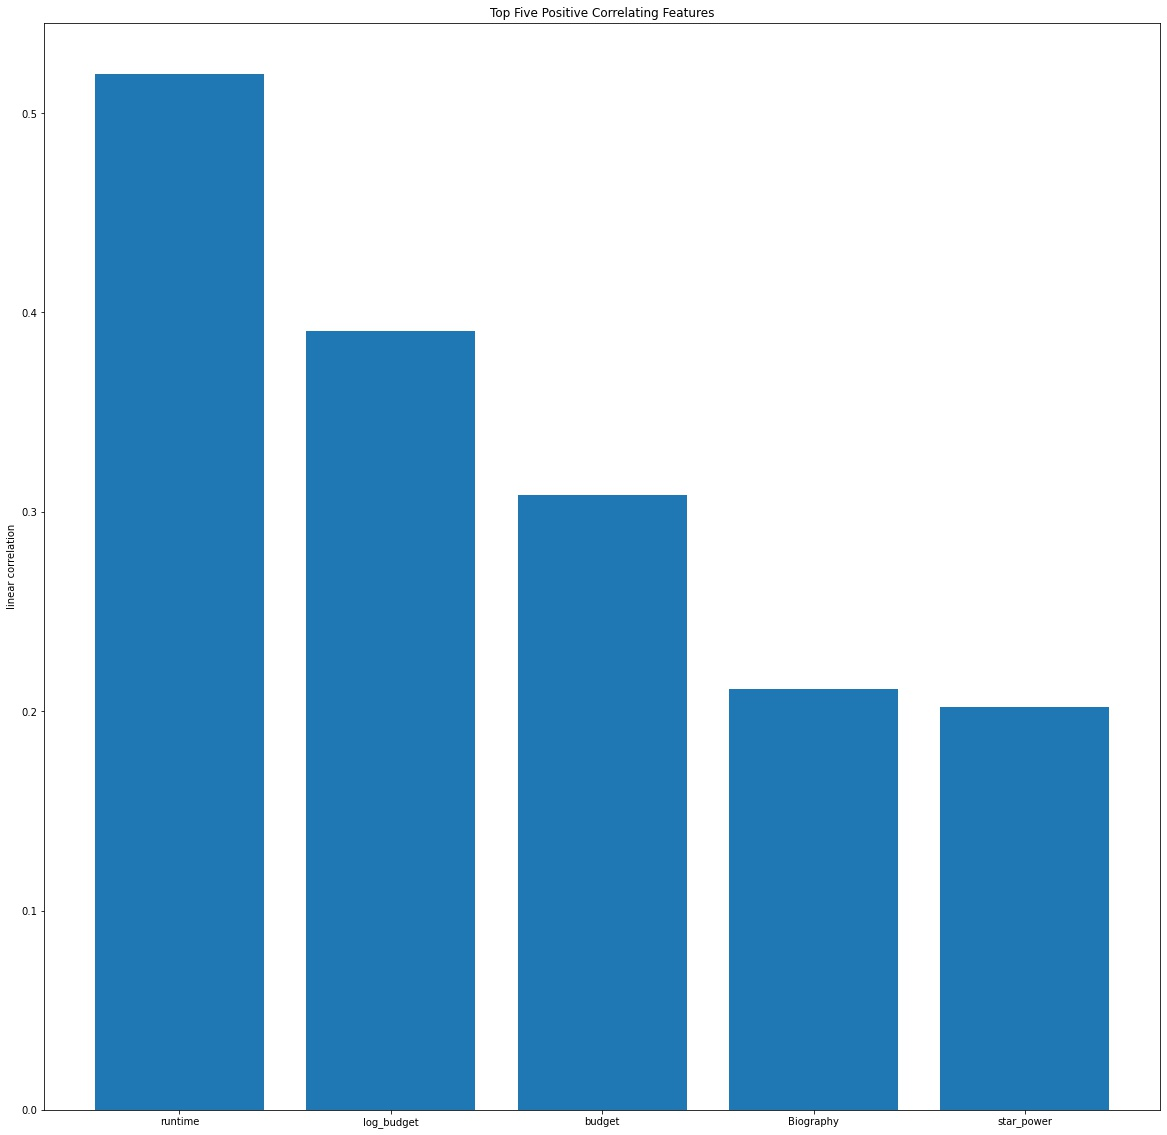

In [277]:
#top 5 positive correlations
plt.figure(figsize=(20,20))
plt.ylabel("linear correlation")
plt.title("Top Five Positive Correlating Features")
plt.bar(movie_for_modelling_corr_df.iloc[1:6,0],movie_for_modelling_corr_df.iloc[1:6,1])
plt.savefig("top5_positive.png")
plt.show();


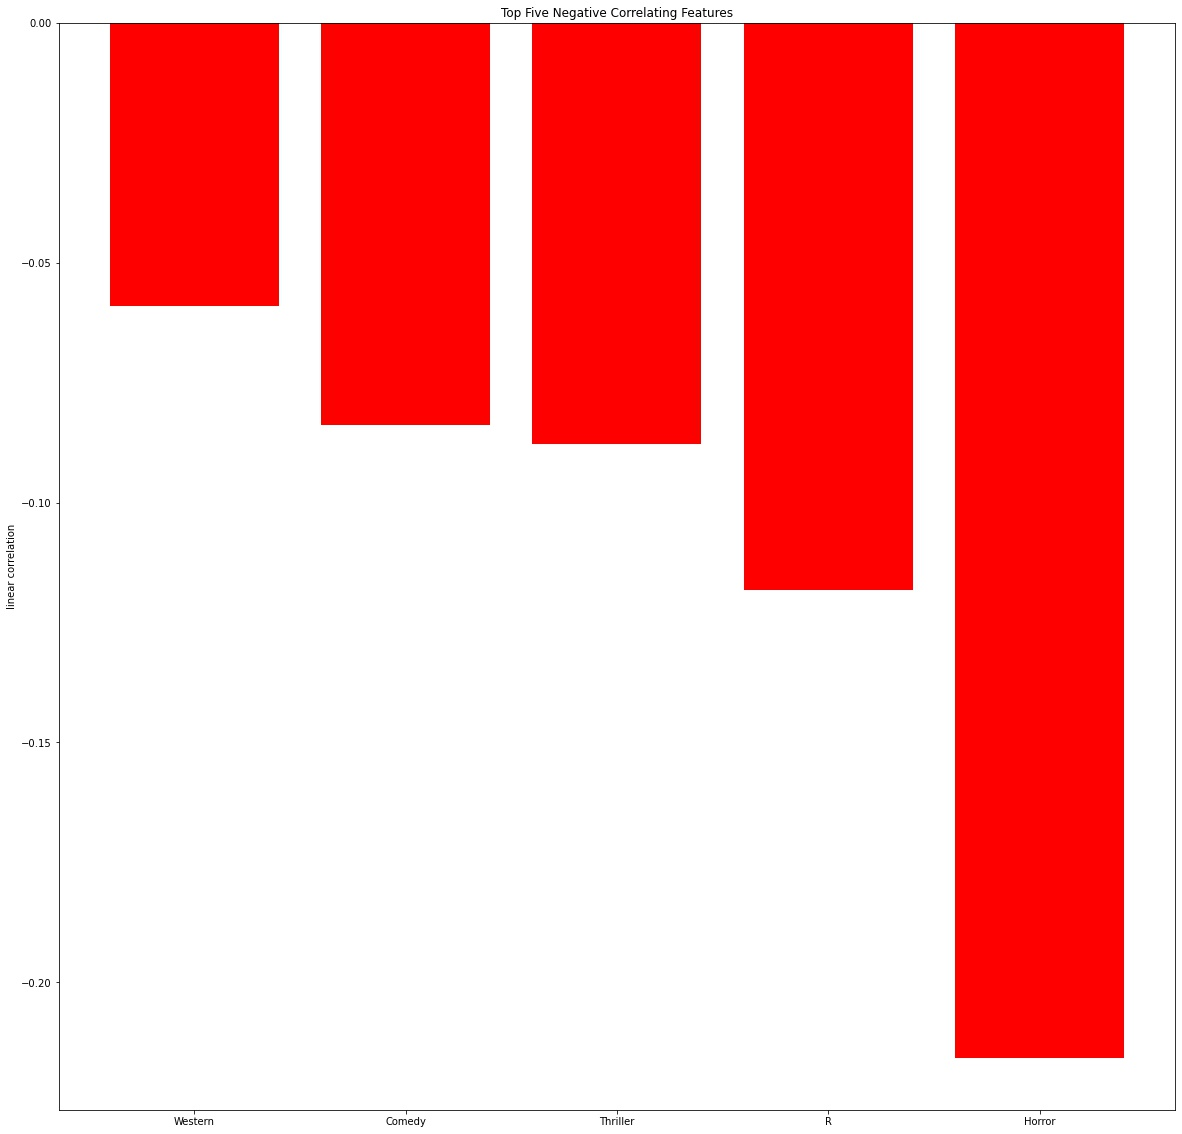

In [278]:
#top 5 neative correlations
plt.figure(figsize=(20,20))
plt.ylabel("linear correlation")
plt.title("Top Five Negative Correlating Features")
plt.bar(movie_for_modelling_corr_df.iloc[-7:,0],movie_for_modelling_corr_df.iloc[-7:,1],color="red")
plt.savefig("top5_negative.png")
plt.show();

### Residule Plot

In [284]:
Y_test.shape

(213,)

# Challenge 1
Plot domestic gross over time


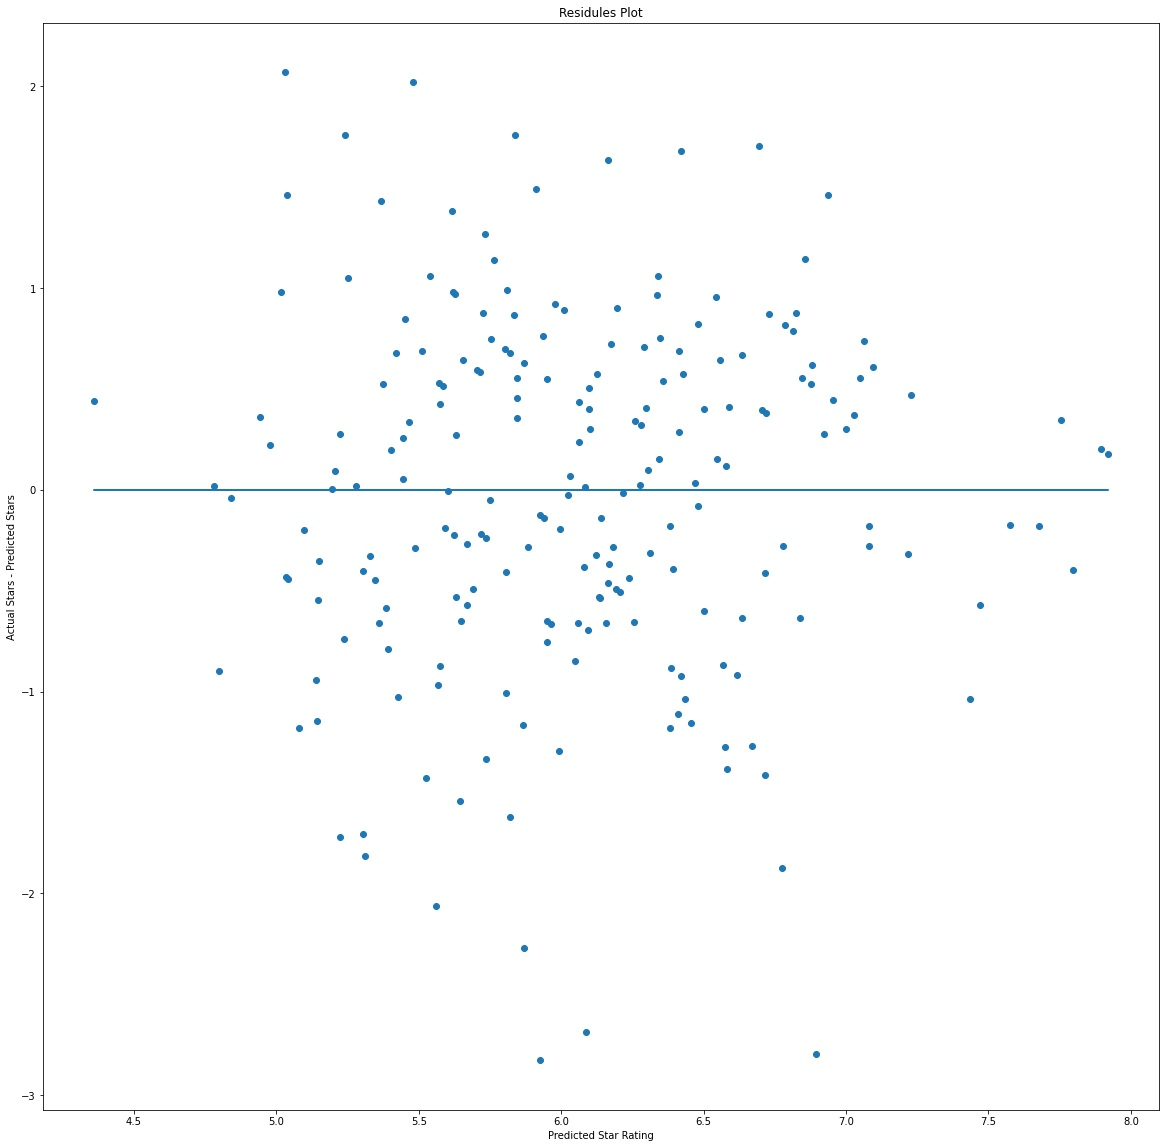

In [287]:
Y_hat = model3.predict(X_test)
residules = Y_test - Y_hat
plt.figure(figsize=(20,20))
plt.scatter(Y_hat,residules)
plt.plot(Y_hat,np.zeros(Y_hat.shape[0]))
plt.title("Residules Plot")
plt.xlabel("Predicted Star Rating")
plt.ylabel("Actual Stars - Predicted Stars")
plt.savefig("residules.png")
plt.show();

In [288]:
np.mean(residules)

-0.0214690898866381

/Users/magreen/Anaconda3-2020_07/envs/tensorflow_in_practice/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


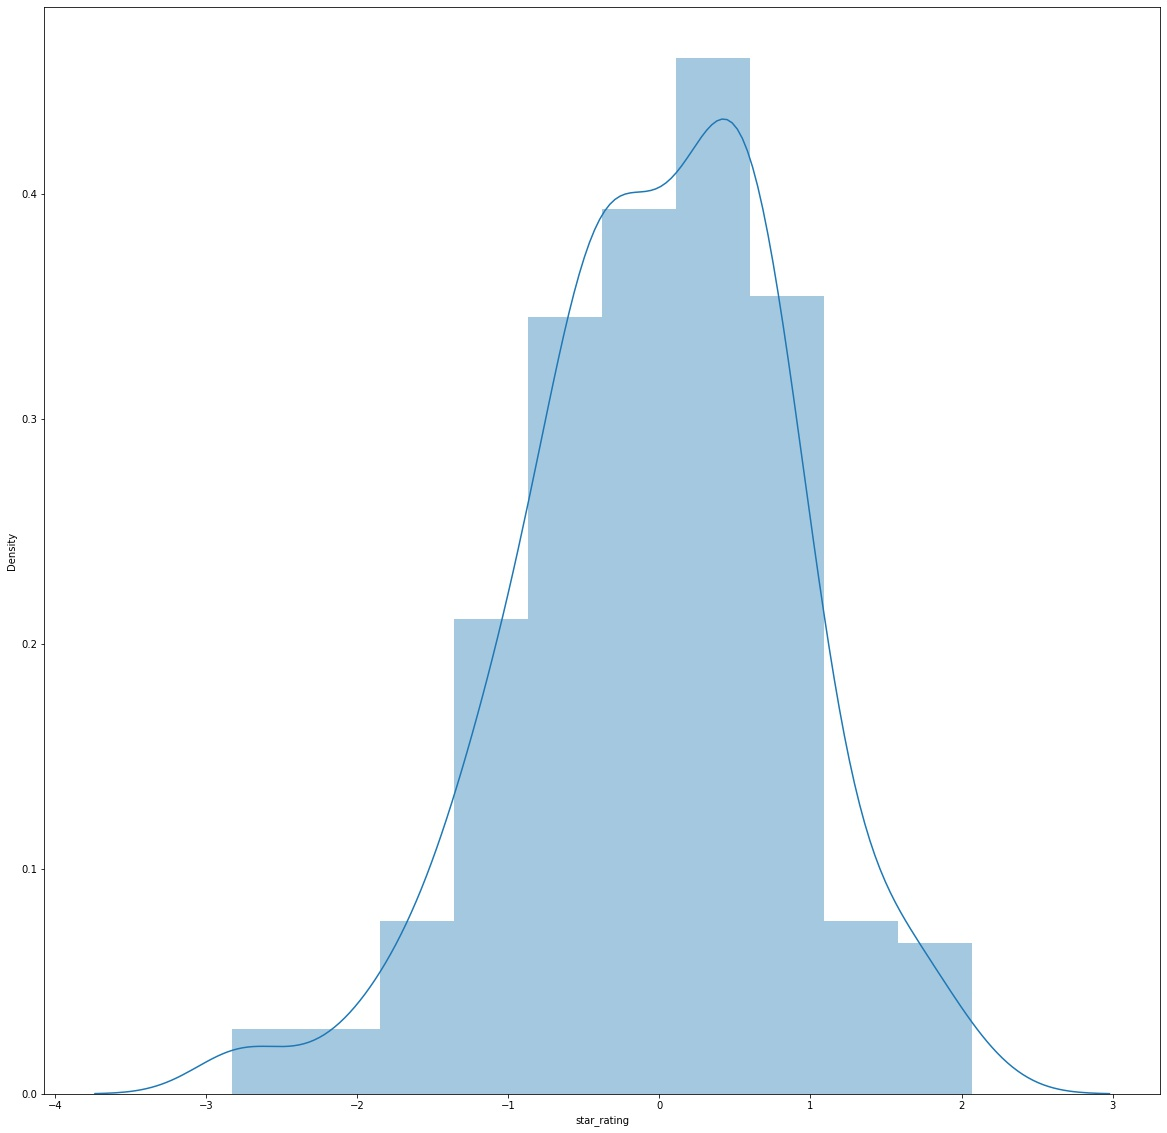

In [296]:
plt.figure(figsize=(20,20))
sns.distplot(residules,bins=10)
plt.savefig("residule_distplot.png");

Q-Q Plot

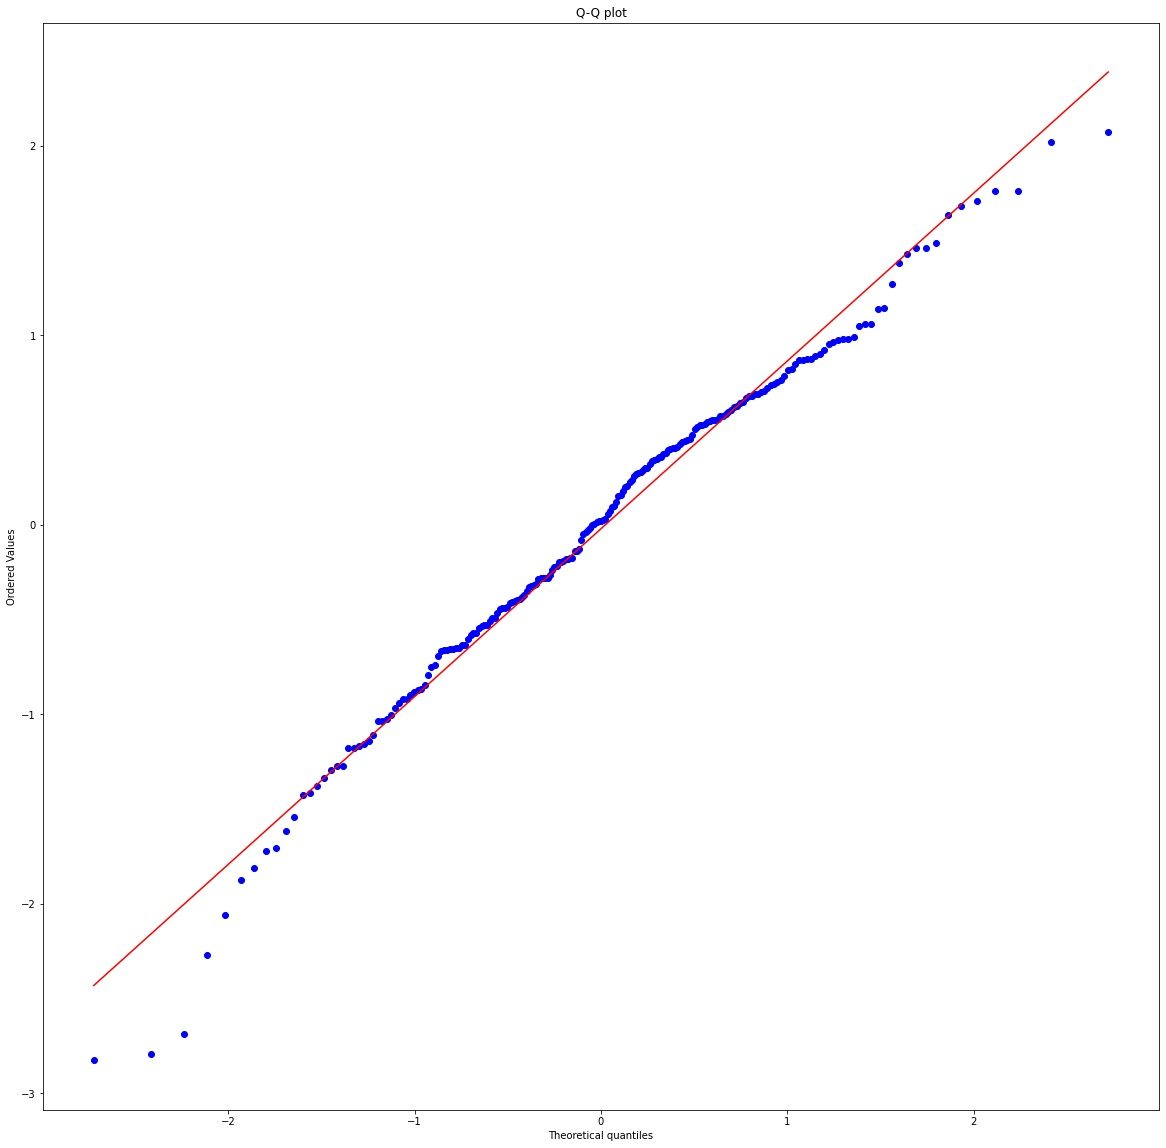

In [305]:
plt.figure(figsize=(20,20))
stats.probplot(residules, dist="norm", plot=plt)
plt.title("Q-Q plot")
plt.savefig("q_q_plot.png")
plt.show();


I interpret this question to mean to plot the domestic gross for movies in the data frame in the order in which movies were released


create a datetime data type column in the data frame

In [ ]:
movie_df["releasedDateTime"] = pd.to_datetime( movie_df["releaseDate"] )

In [ ]:
movie_df.head()

In [ ]:
movie_df.sort_values(["releasedDateTime"],inplace=True)

In [ ]:
movie_df.head()

In [ ]:
movie_df.tail()

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation="vertical")
plt.plot(movie_df["releasedDateTime"],movie_df["domesticTotalGross"])
plt.title("Plot of Domestic Gross For Movies First Released in 2013")
plt.xlabel("Date")
plt.ylabel("Gross in Dollars")
plt.show()

# Challenge 2
Plot runtime vs. domestic total gross.

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation="vertical")
plt.scatter(movie_df["runtime"],movie_df["domesticTotalGross"],alpha=0.15,color="green")
plt.title("Plot of Domestic Gross vs Run Timr in 2013")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")
plt.show()

# Challenge 3
Group your data by Rating and find the average runtime and domestic total gross at each level of Rating.


In [ ]:
movie_avgruntime_per_rating_df = movie_df.groupby(["rating"])["runtime"].mean().reset_index()

In [ ]:
movie_avgruntime_per_rating_df.head()

In [ ]:
movie_avgruntime_per_rating_df.rename(columns={"runtime":"avg_runtime"},inplace=True)

In [ ]:
movie_avgruntime_per_rating_df

In [ ]:
movie_totdomgross_per_rating_df = movie_df.groupby(["rating"])["domesticTotalGross"].sum().reset_index()

In [ ]:
movie_totdomgross_per_rating_df

In [ ]:
movie_totdomgross_per_rating_df.sort_values(["domesticTotalGross"], inplace=True)

In [ ]:
movie_totdomgross_per_rating_df

# Challenge 4
Make one figure with (N=the number of MPAA ratings there are) subplots, and in each plot the release date vs the domestic total gross.



In [ ]:
 movie_df["rating"].value_counts()

What are the movies with no MPAA Rating?

In [ ]:
pd.set_option('display.max_rows', 20)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
movie_df[ movie_df["rating"]=="" ].head(100)

In [ ]:
plt.figure(figsize=(20,20))
plt.suptitle('domestic tot gross vs release date for movies with the same MPAA rating',fontsize = 16)


plt.subplot(3,2,1) # (number of rows, number of columns, number of plot)
plt.scatter(movie_df[ movie_df["rating"]=="" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="" ]["domesticTotalGross"],alpha=0.2)
plt.title("MPAA Rating Unknown")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,2)
plt.scatter(movie_df[ movie_df["rating"]=="R" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="R" ]["domesticTotalGross"],alpha=0.2,color="green")
plt.title("MPAA Rated R")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,3)
plt.scatter(movie_df[ movie_df["rating"]=="PG-13" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="PG-13" ]["domesticTotalGross"],alpha=0.2,color="purple")
plt.title("MPAA Rated PG-13")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,4)
plt.scatter(movie_df[ movie_df["rating"]=="PG" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="PG" ]["domesticTotalGross"],alpha=0.2,color="red")
plt.title("MPAA Rated PG")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,5)
plt.scatter(movie_df[ movie_df["rating"]=="NC-17" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="NC-17" ]["domesticTotalGross"],color="red",marker="+")
plt.title("MPAA Rated NC-17")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars")

plt.subplot(3,2,6)
plt.scatter(movie_df[ movie_df["rating"]=="PG-" ]["releasedDateTime"], movie_df[ movie_df["rating"]=="PG-" ]["domesticTotalGross"],color="black")
plt.title("MPAA Rated PG- (most likely rated PG-13)")
plt.xlabel("Run Time in Minutes")
plt.ylabel("Gross in Dollars");


# Challenge 5
What director in your dataset has the highest gross per movie?

Find the gross per director


In [ ]:
movie_totgross_per_director_df = movie_df.groupby(["director"])["domesticTotalGross"].sum().reset_index()

In [ ]:
movie_totgross_per_director_df.sort_values(["domesticTotalGross"],inplace=True,ascending=False)

In [ ]:
movie_totgross_per_director_df.head()

[Francis Lawrence](https://en.wikipedia.org/wiki/Francis_Lawrence) is pretty prolific so the data here seems right.

# Challenge 6
Bin your dataset into months and make a bar graph of the mean domestic total gross by month. Error bars will represent the standard error of the mean.

Title of graph should include: Mean Domestic Total Gross by Month in 2013

Topic for consideration: what is the correct formula for the standard error of the mean? Examine the error bars and see if they are “reasonable.”

Create a new column that holds the name of the month of the release date for  the movie in the same row as the release date

In [ ]:
import seaborn as sns

In [ ]:
movie_df["releasedMonth"] = movie_df["releasedDateTime"].dt.month_name()
movie_df["releasedMonthNumber"] = pd.DatetimeIndex(movie_df["releasedDateTime"]).month

In [ ]:
movie_avggross_per_month = movie_df.groupby(["releasedMonthNumber","releasedMonth"])["domesticTotalGross"].mean().reset_index()

In [ ]:
movie_avggross_per_month.rename(columns={"domesticTotalGross":"domesticMeanGross"},inplace=True)

In [ ]:
movie_avggross_per_month.sort_values(["releasedMonthNumber"],inplace=True)

In [ ]:
movie_avggross_per_month

In [ ]:



months_of_the_year = ["January","February","March","April","May","June","July","August","September","October","November","December"]
list_of_domestic_gross = []

for month_name in months_of_the_year:
    list_of_domestic_gross.append( movie_avggross_per_month[movie_avggross_per_month["releasedMonth"]==month_name]["domesticMeanGross"] )

In [ ]:
#len(list_of_domestic_gross)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(months_of_the_year,list_of_domestic_gross)
plt.xticks(rotation=60)
plt.xlabel("Month of the Year")
plt.ylabel("AVG Domestic Gross")
plt.title("AVG Domestic Gross for all movies released in month on X-axis in 2013")
plt.show();

In [ ]:
plt.figure(figsize=(20,20))
sns.boxplot(y=movie_avggross_per_month["domesticMeanGross"],x=movie_avggross_per_month["releasedMonthNumber"]);
#movie_avggross_per_month.boxplot(figsize=(20,10),by="releasedMonthNumber")

Going to attempt to pull up web site data for movies by name

From inspecting the search result HTML all links to movies are found under these types of HTML elements:

```html
<div class="lister-item-content">
    <h3 class="lister-item-header">
    <!-- Stuff -->
    <a href="LINK_TO_MOVIE">NAME_OF_MOVIE</a>
    <!-- Stuff -->
    </h3>
</div>
      

```

So I should grab all the `<div>` tags with that class and then get the link within them


IMDB Only shows the first 50 movies when you request search results.

So I will need the link to the next 50 movies.

That is located in the web page returned on the search request here:

```html

<div class="desc">
    <a href="LINK_TO_NEXT_PAGE_IN_SEARCH_RESULTS">Next<!--text--></a>
</div>

```